In [8]:
import pandas as pd

df = pd.read_csv("/content/data/customer_churn_data.csv")

print("Dataset Loaded Successfully")
df.head()


Dataset Loaded Successfully


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST0000,Male,0,No,Yes,23,No,No phone service,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer,49.85,1146.55,No
1,CUST0001,Female,0,Yes,No,43,No,No phone service,DSL,Yes,...,Yes,No,Yes,No,Month-to-month,No,Mailed check,100.70,4330.10,Yes
2,CUST0002,Male,1,No,No,51,Yes,No,DSL,No,...,Yes,Yes,No,No,One year,No,Electronic check,97.33,4963.83,Yes
3,CUST0003,Male,1,No,No,72,Yes,Yes,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Credit card,101.38,7299.36,No
4,CUST0004,Male,1,No,No,25,Yes,Yes,DSL,No,...,No,Yes,No,Yes,Month-to-month,No,Electronic check,52.22,1305.50,Yes


In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# ---------------------------------------------------------
# SAFE TENURE BINNING
# ---------------------------------------------------------
tenure_max = df['tenure'].max()

raw_bins = [-1, 6, 12, 24, 48, 72, tenure_max]
unique_bins = sorted(set(raw_bins))

labels = []
for i in range(len(unique_bins) - 1):
    low = unique_bins[i] + 1
    high = unique_bins[i + 1]
    labels.append(f"{low}-{high}")

df['tenure_bin'] = pd.cut(
    df['tenure'],
    bins=unique_bins,
    labels=labels,
    include_lowest=True
)

# Convert TotalCharges safely
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Target encoding
df['Churn_Encoded'] = df['Churn'].map({"Yes": 1, "No": 0})

print("Feature Engineering Completed")
df[['tenure', 'tenure_bin', 'TotalCharges', 'Churn_Encoded']].head()


Feature Engineering Completed


/tmp/ipython-input-3008382491.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


,tenure,tenure_bin,TotalCharges,Churn_Encoded
0,23,13-24,1146.55,0
1,43,25-48,4330.10,1
2,51,49-72,4963.83,1
3,72,49-72,7299.36,0
4,25,25-48,1305.50,1


In [10]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bin'
]

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("Preprocessor Created")


Preprocessor Created


In [11]:
X = df.drop(columns=['Churn_Encoded', 'Churn'])
y = df['Churn_Encoded']

X_processed = preprocessor.fit_transform(X)

print("Preprocessing Completed")
print("Processed X shape:", X_processed.shape)


Preprocessing Completed
Processed X shape: (5880, 51)


In [12]:
joblib.dump(preprocessor, "preprocessor.joblib")

print("Preprocessor Saved as preprocessor.joblib")


Preprocessor Saved as preprocessor.joblib


In [13]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_processed, y)

joblib.dump(logreg_model, "model_logreg.joblib")

print("Logistic Regression Model Saved")


Logistic Regression Model Saved


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_processed, y)

joblib.dump(rf_model, "model_rf.joblib")

print("Random Forest Model Saved")


Random Forest Model Saved


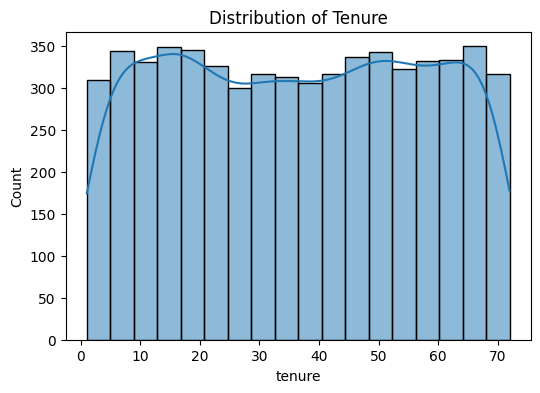

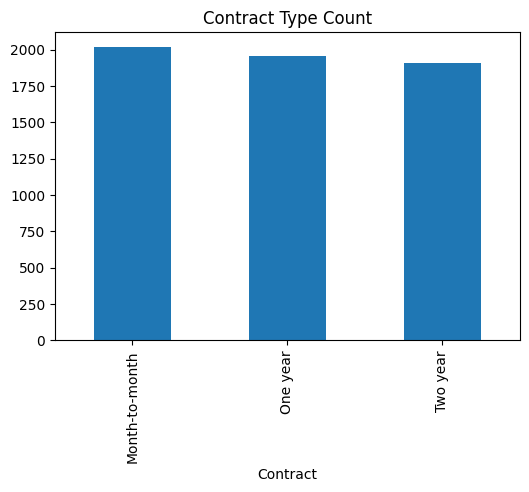

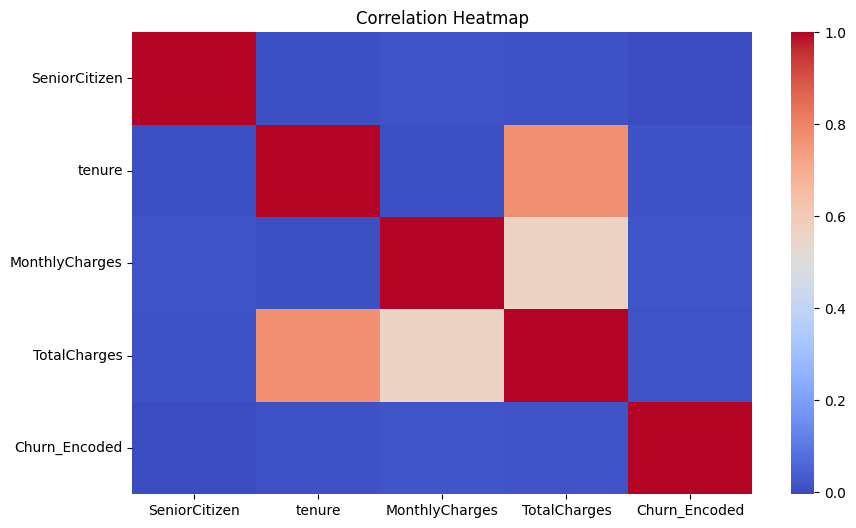

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tenure distribution
plt.figure(figsize=(6,4))
sns.histplot(df['tenure'], kde=True)
plt.title("Distribution of Tenure")
plt.savefig("dist_tenure.png")
plt.show()

# Contract Count
plt.figure(figsize=(6,4))
df['Contract'].value_counts().plot(kind='bar')
plt.title("Contract Type Count")
plt.savefig("cat_counts_contract.png")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig("corr_heatmap.png")
plt.show()